In [1]:
import pandas as pd
import spacy

In [4]:
# Charger les données
df = pd.read_json('reviews.jsonl', lines=True)
print("Aperçu des données initiales :")
print(df.head(20))

Aperçu des données initiales :
    rating                                              title  \
0        4                   No white background! It’s clear!   
1        5                Awesome!  Great price!  Works well!   
2        5                 Worked but took an hour to install   
3        4                                             Decent   
4        5                                           LOVE IT!   
5        5        Works Great with my IPhone 13 & Magna Case!   
6        5                       Great item! Easy to install!   
7        4                                         Four Stars   
8        5  It is a great value & protects the phone from ...   
9        5                         Good to have these around!   
10       5                                        These work!   
11       5                 Finally something I can Hang onto!   
12       5                               Great, great, great!   
13       5                                       Great valu

In [5]:
# Sélection des champs pertinents
df = df[['rating', 'title', 'text']]
print("\nDonnées avec champs sélectionnés :")
print(df.head())


Données avec champs sélectionnés :
   rating                                title  \
0       4     No white background! It’s clear!   
1       5  Awesome!  Great price!  Works well!   
2       5   Worked but took an hour to install   
3       4                               Decent   
4       5                             LOVE IT!   

                                                text  
0  I bought this bc I thought it had the nice whi...  
1  Perfect. How pissed am I that I recently paid ...  
2  Overall very happy with the end result. If you...  
3  Lasted about 9 months then the lock button bro...  
4  LOVE THIS CASE! Works better than my expensive...  


In [6]:
# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")

In [7]:
# Fonction de prétraitement
def preprocess_text_spacy(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if (
            not token.is_stop  # Exclure les stop words
            and token.is_alpha  # Exclure les symboles et chiffres
            and len(token) > 2  # Exclure les mots courts
        ):
            tokens.append(token.lemma_)  # Lemmatisation (normalisation des mots, ex : "était" -> "être")
    return tokens

In [8]:
# Appliquer la fonction de prétraitement
df['processed_tokens'] = df['text'].apply(preprocess_text_spacy)
print("\nDonnées après prétraitement :")
print(df.head())


Données après prétraitement :
   rating                                title  \
0       4     No white background! It’s clear!   
1       5  Awesome!  Great price!  Works well!   
2       5   Worked but took an hour to install   
3       4                               Decent   
4       5                             LOVE IT!   

                                                text  \
0  I bought this bc I thought it had the nice whi...   
1  Perfect. How pissed am I that I recently paid ...   
2  Overall very happy with the end result. If you...   
3  Lasted about 9 months then the lock button bro...   
4  LOVE THIS CASE! Works better than my expensive...   

                                    processed_tokens  
0  [buy, think, nice, white, background, turn, cl...  
1  [perfect, pissed, recently, pay, fitbit, cable...  
2  [overall, happy, end, result, hate, puzzle, lo...  
3  [last, month, lock, button, break, decent, pro...  
4     [love, case, work, well, expensive, case, lol]  


In [9]:
# Sauvegarder les données prétraitées si nécessaire
df.to_csv('processed_reviews.csv', index=False)
print("\nLes données prétraitées ont été sauvegardées dans 'processed_reviews.csv'.")


Les données prétraitées ont été sauvegardées dans 'processed_reviews.csv'.


In [10]:
#Étape 2 : Génération des embeddings

In [11]:
# Charger les données prétraitées
df = pd.read_csv('processed_reviews.csv')
documents = df['processed_tokens'].apply(eval)  # Convertir les chaînes de tokens en listes Python
documents = [" ".join(tokens) for tokens in documents]  # Convertir les listes en chaînes
print(f"Nombre de documents : {len(documents)}")

Nombre de documents : 1000


In [12]:
#2. Génération des embeddings 
#Option  : Utiliser TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Configurer et appliquer TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiter à 5000 caractéristiques
tfidf_embeddings = tfidf_vectorizer.fit_transform(documents)
print(f"Taille de la matrice TF-IDF : {tfidf_embeddings.shape}")
print("Exemple d'embedding TF-IDF :")
print(tfidf_embeddings.toarray()[:2])


Taille de la matrice TF-IDF : (1000, 2592)
Exemple d'embedding TF-IDF :
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
#Option 2 : Utiliser SentenceTransformers (all-MiniLM-L6-v2)
#from sentence_transformers import SentenceTransformer

# Charger le modèle SentenceTransformers
#model = SentenceTransformer('all-MiniLM-L6-v2')

# Générer les embeddings pour chaque document
#embeddings = model.encode(documents, show_progress_bar=True)
#print(f"Taille des embeddings : {embeddings.shape}")


In [14]:
# 3. Clustering
#Option : DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Appliquer DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='cosine')  # 'cosine' est recommandé pour les données textuelles
dbscan_labels = dbscan.fit_predict(tfidf_embeddings)

# Nombre de clusters identifiés (ignorer le bruit, label = -1)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Nombre de clusters identifiés : {num_clusters}")

Nombre de clusters identifiés : 4


In [15]:
from sklearn.metrics import silhouette_score

# Filtrer les points de bruit (-1)
valid_points = dbscan_labels != -1
if valid_points.any():  # Vérifie si des clusters valides existent
    silhouette_avg = silhouette_score(
        tfidf_embeddings[valid_points], dbscan_labels[valid_points], metric='cosine'
    )
    print(f"\nScore de silhouette moyen (sans le bruit) : {silhouette_avg:.3f}")
else:
    print("\nImpossible de calculer le score de silhouette : aucun cluster valide.")


Score de silhouette moyen (sans le bruit) : 0.360


In [16]:
#4. Analyse des clusters : 

from collections import defaultdict

# Associer les documents à leurs clusters
clusters = defaultdict(list)
for i, label in enumerate(dbscan_labels):
    clusters[label].append(documents[i])

# Analyser les mots-clés dans chaque cluster
from sklearn.feature_extraction.text import CountVectorizer

for cluster_id, docs in clusters.items():
    print(f"\nCluster {cluster_id} :")
    vectorizer = CountVectorizer(max_features=20)  # Limiter à 10 mots-clés
    word_counts = vectorizer.fit_transform(docs)
    words = vectorizer.get_feature_names_out()
    freqs = word_counts.sum(axis=0).A1
    keywords = sorted(zip(words, freqs), key=lambda x: -x[1])
    print("Mots-clés les plus fréquents :", keywords)



Cluster -1 :
Mots-clés les plus fréquents : [('phone', 757), ('case', 576), ('work', 259), ('great', 222), ('like', 220), ('good', 212), ('fit', 208), ('charge', 199), ('screen', 184), ('use', 176), ('love', 170), ('easy', 154), ('look', 148), ('time', 137), ('need', 119), ('get', 117), ('iphone', 117), ('cover', 111), ('nice', 108), ('new', 100)]

Cluster 0 :
Mots-clés les plus fréquents : [('great', 34), ('work', 17), ('fit', 8), ('case', 7), ('look', 5), ('phone', 4), ('color', 3), ('feel', 2), ('product', 2), ('protect', 2), ('mandela', 1), ('need', 1), ('nice', 1), ('perfect', 1), ('perfectly', 1), ('plus', 1), ('protection', 1), ('stick', 1), ('sturdy', 1), ('want', 1)]

Cluster 1 :
Mots-clés les plus fréquents : [('love', 25), ('case', 9), ('beautiful', 4), ('husband', 4), ('color', 3), ('phone', 2), ('product', 2), ('good', 1), ('great', 1), ('look', 1), ('new', 1), ('nice', 1), ('perfect', 1), ('piece', 1), ('price', 1), ('purchase', 1), ('recommend', 1), ('size', 1), ('thing

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Étape 1 : Regrouper les documents par cluster
cluster_docs = {cluster_id: " ".join(docs) for cluster_id, docs in clusters.items()}

# Étape 2 : Préparer les données pour c-TFIDF
# On crée un DataFrame où chaque ligne représente un "document" correspondant à un cluster
df_clusters = pd.DataFrame(list(cluster_docs.items()), columns=["cluster_id", "text"])

# Étape 3 : Calculer le c-TFIDF
vectorizer = TfidfVectorizer(max_features=20)  # Limiter le nombre de mots-clés
tfidf_matrix = vectorizer.fit_transform(df_clusters["text"])
terms = vectorizer.get_feature_names_out()

# Étape 4 : Afficher les mots-clés par cluster triés par score
for i, cluster_id in enumerate(df_clusters["cluster_id"]):
    print(f"\nCluster {cluster_id} :")
    scores = tfidf_matrix[i].toarray().flatten()
    # Trier directement les mots par leur score
    sorted_keywords = sorted(zip(terms, scores), key=lambda x: -x[1])  # Trier par score décroissant
    sorted_keywords = [(term, round(score, 3)) for term, score in sorted_keywords if score > 0]  # Garder les scores positifs
    print("Mots-clés les plus caractéristiques :", sorted_keywords)



Cluster -1 :
Mots-clés les plus caractéristiques : [('phone', 0.542), ('case', 0.488), ('screen', 0.277), ('like', 0.222), ('work', 0.219), ('use', 0.213), ('charge', 0.169), ('great', 0.159), ('good', 0.152), ('fit', 0.149), ('get', 0.142), ('time', 0.138), ('cover', 0.135), ('easy', 0.13), ('look', 0.125), ('love', 0.122), ('need', 0.12), ('iphone', 0.118), ('review', 0.102), ('nice', 0.077)]

Cluster 0 :
Mots-clés les plus caractéristiques : [('great', 0.812), ('work', 0.48), ('case', 0.198), ('fit', 0.191), ('look', 0.141), ('phone', 0.096), ('iphone', 0.034), ('like', 0.034), ('need', 0.034), ('charge', 0.028), ('good', 0.024), ('love', 0.024), ('nice', 0.024)]

Cluster 1 :
Mots-clés les plus caractéristiques : [('love', 0.911), ('case', 0.388), ('phone', 0.073), ('time', 0.051), ('charge', 0.043), ('easy', 0.043), ('look', 0.043), ('work', 0.043), ('fit', 0.036), ('good', 0.036), ('great', 0.036), ('nice', 0.036)]

Cluster 2 :
Mots-clés les plus caractéristiques : [('good', 0.88

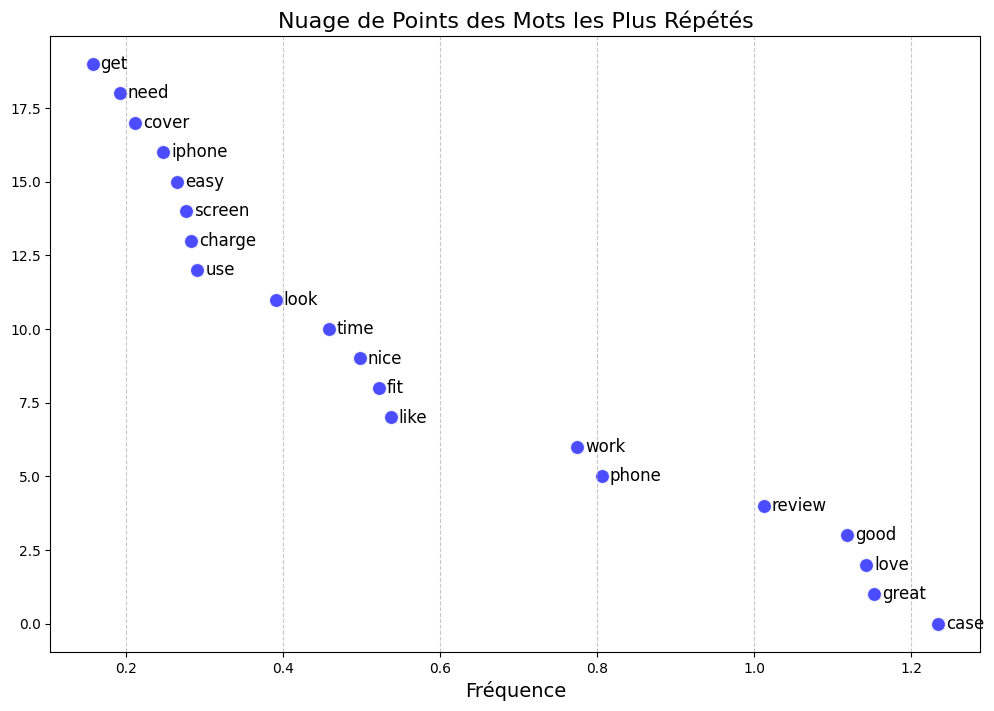

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Calculer les fréquences globales des mots
from collections import Counter

global_keywords = Counter()
for i in range(tfidf_matrix.shape[0]):
    scores = tfidf_matrix[i].toarray().flatten()
    for term, score in zip(terms, scores):
        global_keywords[term] += score

# Extraire les mots et leurs scores
most_common = global_keywords.most_common(20)  # Prendre les 20 mots les plus fréquents
words, frequencies = zip(*most_common)

# Étape 2 : Création du nuage de points
plt.figure(figsize=(12, 8))
sns.scatterplot(x=frequencies, y=range(len(words)), s=100, color="blue", alpha=0.7)

# Ajouter les mots en tant qu'annotations
for i, word in enumerate(words):
    plt.text(frequencies[i] + 0.01, i, word, fontsize=12, va='center')

# Configurer le graphique
plt.title("Nuage de Points des Mots les Plus Répétés", fontsize=16)
plt.xlabel("Fréquence", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



Visualisation pour le Cluster 0 (Fréquences simples) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=words, palette="viridis")


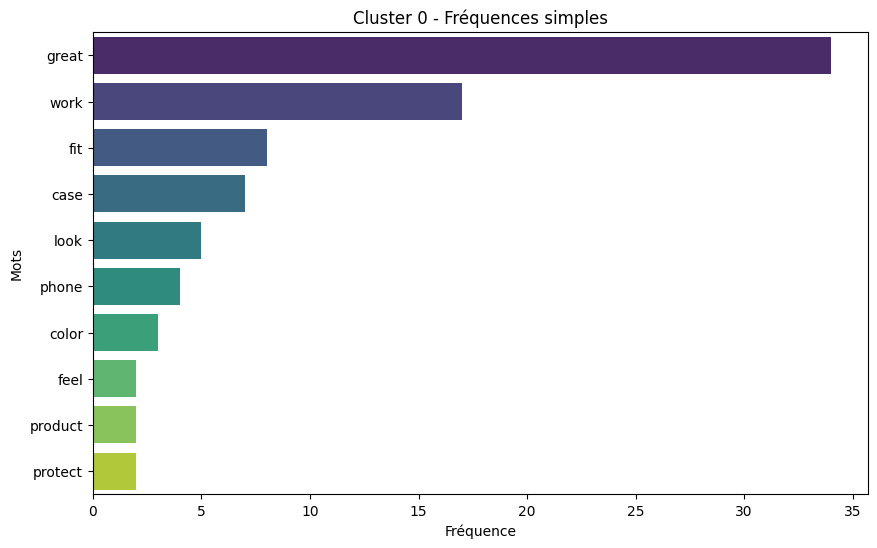


Visualisation pour le Cluster 1 (Fréquences simples) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=words, palette="viridis")


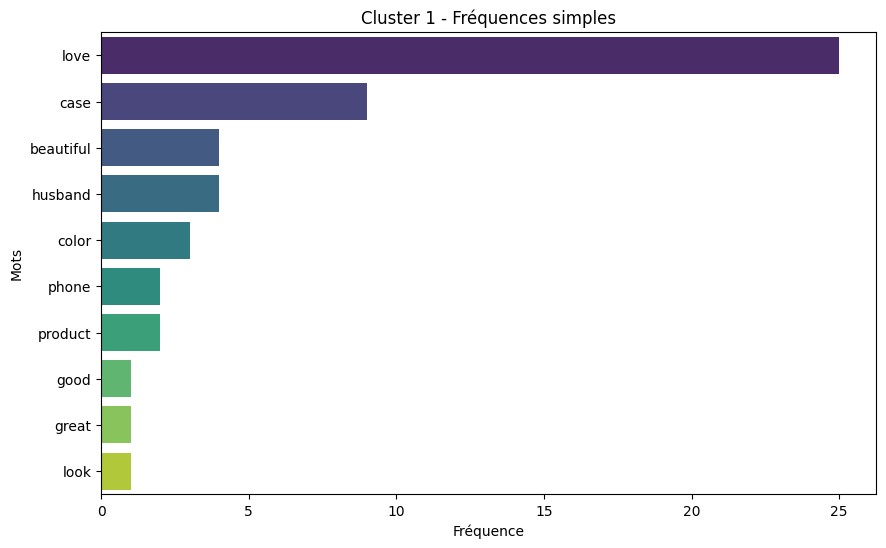


Visualisation pour le Cluster 2 (Fréquences simples) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=words, palette="viridis")


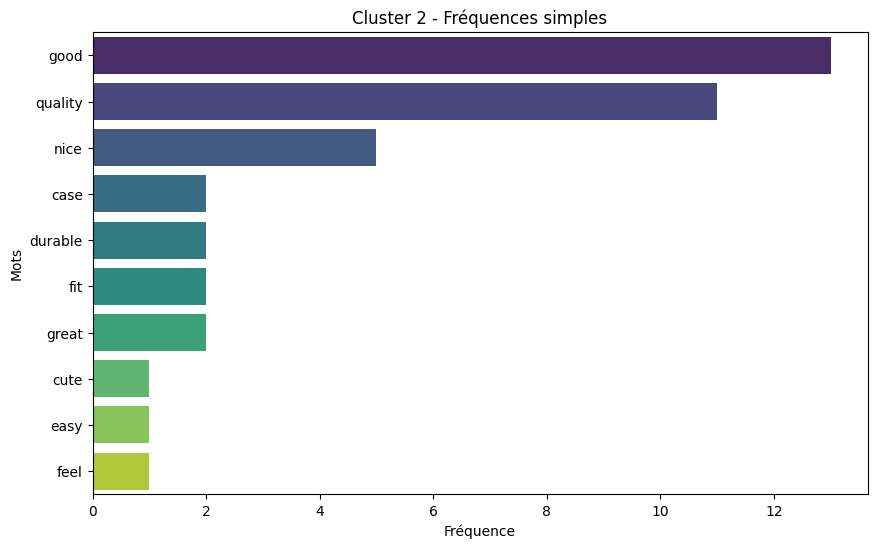


Visualisation pour le Cluster 3 (Fréquences simples) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs, y=words, palette="viridis")


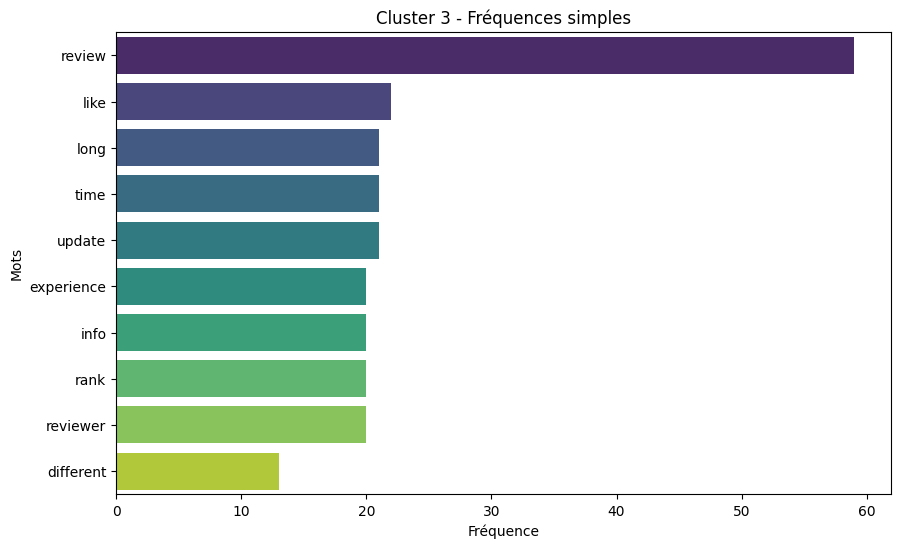


Visualisation pour le Cluster 0 (c-TFIDF) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="mako")


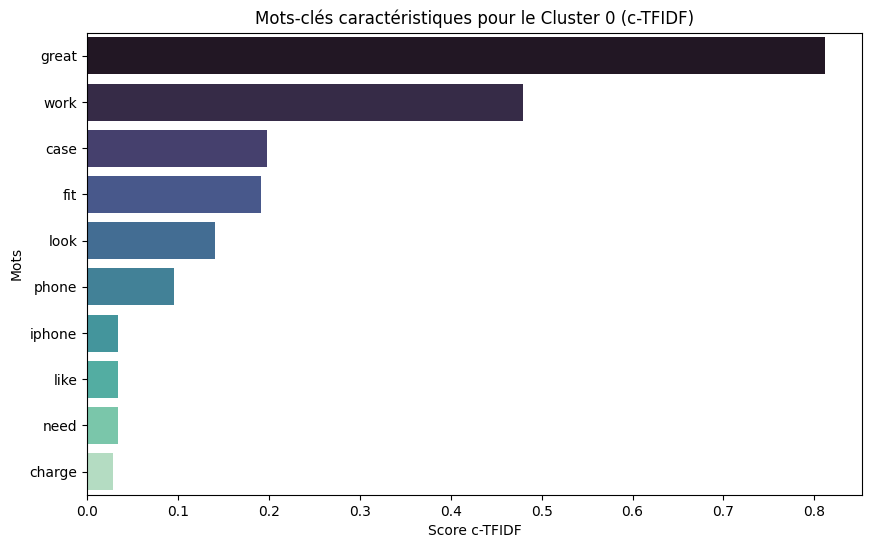


Visualisation pour le Cluster 1 (c-TFIDF) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="mako")


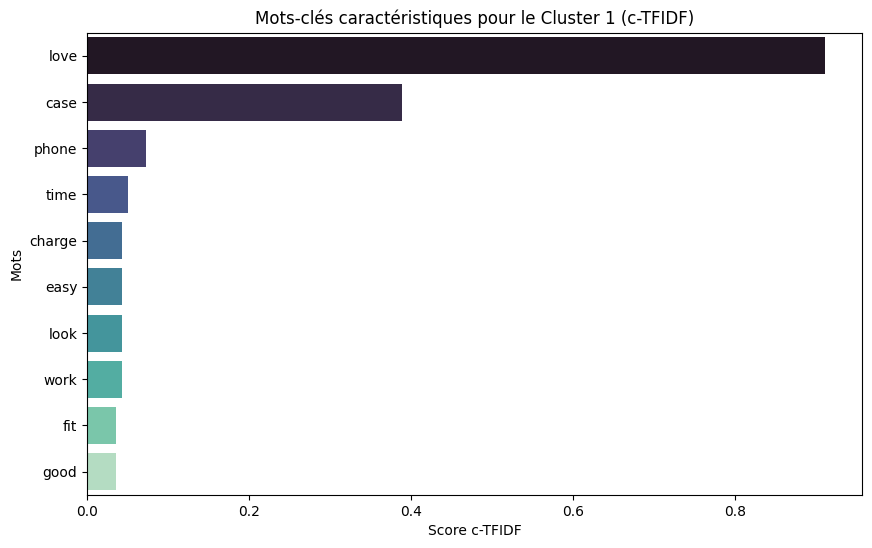


Visualisation pour le Cluster 2 (c-TFIDF) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="mako")


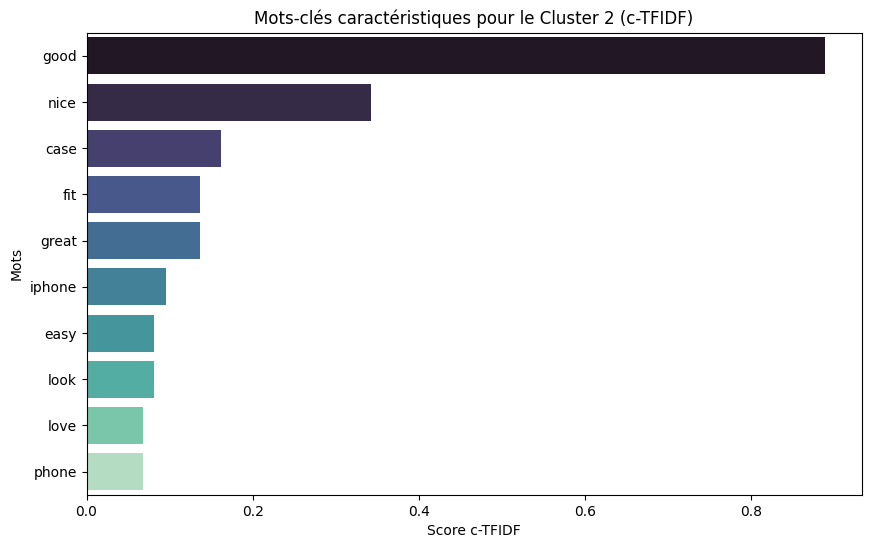


Visualisation pour le Cluster 3 (c-TFIDF) :


C:\Users\anisb\AppData\Local\Temp\ipykernel_17108\551870324.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette="mako")


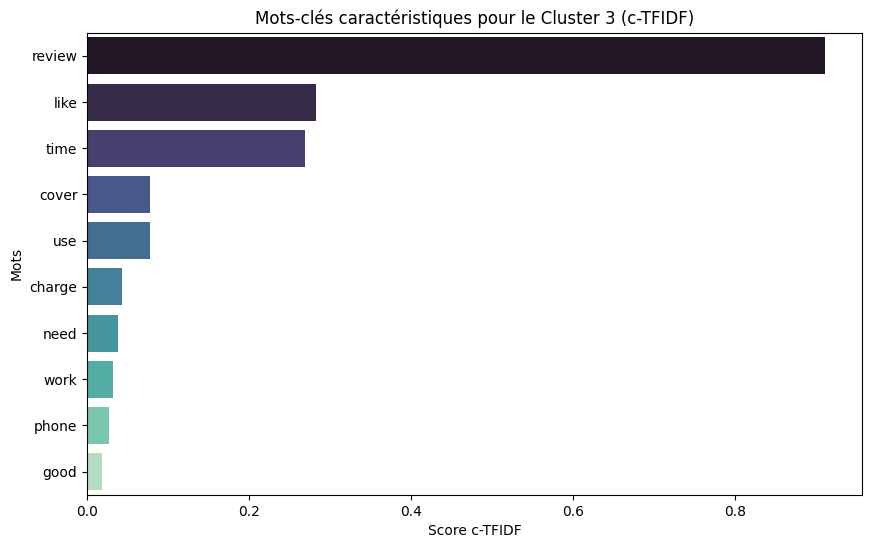

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisation des mots-clés avant application de c-TFIDF
def plot_word_frequencies(keywords, title, top_n=10):
    words, freqs = zip(*keywords[:top_n])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=words, palette="viridis")
    plt.title(title)
    plt.xlabel("Fréquence")
    plt.ylabel("Mots")
    plt.show()

# Visualisation des mots-clés après application de c-TFIDF
def plot_ctfidf_keywords(keywords, cluster_id, top_n=10):
    words, scores = zip(*keywords[:top_n])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=scores, y=words, palette="mako")
    plt.title(f"Mots-clés caractéristiques pour le Cluster {cluster_id} (c-TFIDF)")
    plt.xlabel("Score c-TFIDF")
    plt.ylabel("Mots")
    plt.show()

# Associer les documents à leurs clusters, en excluant le cluster -1
from collections import defaultdict

clusters = defaultdict(list)
for i, label in enumerate(dbscan_labels):
    if label != -1:
        clusters[label].append(documents[i])

# Afficher les mots par fréquence pour chaque cluster avant c-TFIDF
for cluster_id, docs in clusters.items():
    print(f"\nVisualisation pour le Cluster {cluster_id} (Fréquences simples) :")
    vectorizer = CountVectorizer(max_features=20)
    word_counts = vectorizer.fit_transform(docs)
    words = vectorizer.get_feature_names_out()
    freqs = word_counts.sum(axis=0).A1
    keywords = sorted(zip(words, freqs), key=lambda x: -x[1])
    plot_word_frequencies(keywords, f"Cluster {cluster_id} - Fréquences simples")

# Afficher les mots après c-TFIDF
for i, cluster_id in enumerate(df_clusters["cluster_id"]):
    if cluster_id != -1:
        print(f"\nVisualisation pour le Cluster {cluster_id} (c-TFIDF) :")
        scores = tfidf_matrix[i].toarray().flatten()
        sorted_keywords = sorted(zip(terms, scores), key=lambda x: -x[1])
        sorted_keywords = [(term, round(score, 3)) for term, score in sorted_keywords if score > 0]
        plot_ctfidf_keywords(sorted_keywords, cluster_id)
        
